# PHYS 201: Data Analysis for Physicists 
## Final Project Tutorial Notebook

Authors: I. Davenport, N. DePorzio

--------------
--------------   

## "model21cm" :  A TOOLKIT FOR 21CM COSMOLOGY MODEL INFERENCE

--------------
--------------

## Introduction to the Model,  Physics and Inference Package

The name of our package for analyzing data for the sky-averaged temperature of 21cm emissions of interstallar hydrogen is _model21cm_. This package, written in Python3, can be installed and imported like so:  

`$pip install model21cm`

`>>>import model21cm`

Below, we will utilize several examples to demonstrate some features of `model21cm`. We begin by importing a few other useful packages... 

In [1]:
import emcee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The `model21cm` package is meant to analyze data that might be collected from a radio antenna designed to measure the redshifted 21cm signal from the Epoch of Reionization (EoR) in the cosmological history of the Universe. The observable in this experiment is the brightness temperature (proxy for intensity) of the sky in a subset of the radio frequency range - a measure of the monopole moment of the signal. The brightness temperature seen by the detector is the sum of a foreground signal $T_F(\nu)$ and the 21-cm absorption profile $T_{21}(\nu)$.  The 21-cm signal is the absorption we expect from a time in the Universe's history called the Epoch of Reionization. In this epoch the first stars formed and emitted UV light - this light then proceeded to heat the interstellar hydrogen gas. This hot hydrogen gas then absorbed photons from the CMB which allowed it to make a hyperfine transition. The missing part of the spectrum is what we want to model. We follow the convention used by the EDGES experiment in the field of 21-cm cosmology and model $T_{21}$ as a flattened Gaussian. We can loosely justify this model by considering that the EoR has some finite duration and, since the universe is expanding, photons emitted (or aborbed) at a given frequency will be redshifted by different amounts depending on how long ago they were emitted (absorbed). So, we choose 

\begin{equation}
T_{21}(\nu) = -A \left(\frac{1-e^{-\tau e^B}}{1-e^{-\tau}}\right)
\end{equation}

where 

$$B = \frac{4(\nu-\nu_0)^2}{w^2}\text{log}\left(\frac{-1}{\tau}\text{log}\left(\frac{1+e^{-\tau}}{2}\right)\right)$$

A is the absorption amplitude, $\nu_0$ is the center frequency, $w$ is the full width at half max and $\tau$ is a parameter controlling how flat it is. 



The foreground signal $T_F$ comes from galactic synchotron radiation and effects in the earth's ionosphere. The galactic signal comes from cosmic rays being accelerated by the magnetic fields inside of galaxies. The ionosphere is a region of the earth's atmosphere that is composed of atoms which have been ionized by the sun.  This ionized layer reflects and emits at radio frequencies. Ionospheric effects are known to scale as $1/\nu^2$ ([see here](https://iopscience.iop.org/article/10.3847/0004-637X/831/1/6/pdf)). The galactic signal has been studied by many groups using a variety of methods (e.g  [*A model of diffuse Galactic radio emission from 10 MHz to 100 GHz* (Tegmark et al.)](https://arxiv.org/abs/0802.1525) and [here](https://arxiv.org/pdf/1404.0887.pdf). The results of these studies is to model $T_F$ as 

$$ T_F = b_0\left(\frac{\nu}{\nu_c}\right)^{-2.5+b_1+b_2\text{log}(\nu/\nu_c)}exp\left(-b_3\left(\nu/\nu_c\right)^2\right) + b_4\left(\frac{\nu}{\nu_c}\right)^{-2}$$

Here, $b_0$ is some overall scale for the foreground, -2.5 is a typical power law spectral index for the galactic signal, $b_1$ is simply allowing for corrections to this power law, $b_2$ captures some extra effects from the foreground (see papers referenced above), $b_3$ captures the attenuation of the galactic signal by the ionosphere 
and $b_4$ captures the effect of emissions by the ionosphere. The analysis used by EDGES,  which we are interested in emulating, uses an approximation to the full $T_F$ term given by: 

\begin{equation}
T_F = a_0\left(\frac{\nu}{\nu_c}\right)^{-2.5} + a_1\left(\frac{\nu}{\nu_c}\right)^{-2.5}\text{log}\left(\frac{\nu}{\nu_c}\right) + a_2\left(\frac{\nu}{\nu_c}\right)^{-2.5}\left(\text{log}\left(\frac{\nu}{\nu_c}\right)\right)^2 + a_3\left(\frac{\nu}{\nu_c}\right)^{-4.5} + a_4\left(\frac{\nu}{\nu_c}\right)^{-2}
\end{equation}

This expression is further approximated to: 

$$T_F = \sum_{n=0}^5 a_n\nu^{n-2.5}$$ 

as in [*An absorption profile centred at 78 megahertz in the sky-averaged spectrum* (Bowman et al)](https://www.nature.com/articles/nature25792). We see no good reason not to use the full model for the foreground but, for now, we use the multiterm polynomial which approximates the model. In any case our MCMC fits the parameters of the model. 


The EDGES data suggests that the absorption trough is much deeper than expected, indicating a misunderstanding in our current model of the evolution of the Universe. The depth of the signal could increase if there are interactions between the hydrogen gas and dark matter particles/radiation. This interaction could cool the hydrogen gas and give it the ability to absorb more of the CMB radiation. 

The novel part of our project is to include into the model a term $T_D$ which will be present if there are interactions between dark matter particles and baryons. The form we posit for $T_D$ is: 

\begin{equation}
T_D = \frac{\xi}{\nu}
\end{equation}

and we want to infer the value of $\xi$. 

At the moment we are considering calibration errors as our only source of noise. The calibration errors are disucssed in Bowman et al. We assume this causes some Gaussian noise which is constant across all frequencies.  From this we write our likelihood function as 

\begin{equation}
\mathcal{L} = \exp\left(-\frac{\chi^2}{2}\right)
\end{equation}

where:  

$$\chi^2 = \frac{1}{\sigma^2}\sum (T_{obs} - (T_F  + T_D + T_{21}))^2$$

A test data set ([which is the actual data provided by the EDGES observation](http://loco.lab.asu.edu/edges/edges-data-release/), courtesy Bowman et al. 2018) for our model comes pre-loaded upon installing `model21cm`. We include the dataset in the package because it is small, and is not very budensome to include with the package download. This data is provided within an instance of the `model21cm.Data` class and can be loaded after importing `model21cm` like so: 

In [2]:
import model21cm as m21


m21.edgesdata.full_data #The full EDGES dataset 
m21.edgesdata.full_data.head() #We print the first few lines - notice the weight 0 points

,Frequency [MHz],Tsky [K],Weight
0,50.012207,0.000000,0
1,50.402832,0.000000,0
2,50.793457,0.000000,0
3,51.184082,4645.468619,1
4,51.574707,4556.501107,1


We can snip out non-physical values which are weighted by 0 in the dataset above using the `Data.snip_data` method...

In [8]:
m21.edgesdata.snip_data('Weight', 1) #Only keep data points with weight 1 
m21.edgesdata.full_data.head() #Print the first few of remaining data points

,Frequency [MHz],Tsky [K],Weight
3,51.184082,4645.468619,1
4,51.574707,4556.501107,1
5,51.965332,4469.791669,1
6,52.355957,4385.322184,1
7,52.746582,4303.120393,1


Now we want to do some inference using user generated data. First, we initialize our model parameters as instances of the `model21cm.Parameter` class. We assign them uniform priors upon initialization. The `Parameter` class also has methods for assigning a Jeffreys prior. Here we load parameters and give them priors set by the results of the EDGES experiment. Here, the intent of our package design is to make it easy to initialize different sets of parameters, with different priors, and thus easily test different configurations on the same model (or on different models that share certain parameters). 

In [9]:
#Define uniform priors on the parameters of our model
a0 = m21.Parameter('a0', 1530., 1650.)
a1 = m21.Parameter('a1', 450., 900.)
a2 = m21.Parameter('a2', -1400., -800.)
a3 = m21.Parameter('a3', 450., 900.)
a4 = m21.Parameter('a4', -225., -125.)
A = m21.Parameter('A', 0.3, 1.0)
tau = m21.Parameter('tau', 4., 12.)
nu0 = m21.Parameter('nu0', 76., 80.)
w = m21.Parameter('w', 17., 24.)

Now, we group these parameters into a set we can then pass into a model. 

In [10]:
parameterlist = [a0, a1, a2, a3, a4, A, tau, nu0, w]
parameters = m21.Parameters(parameter_list=parameterlist)
parameters.parameter_names()

['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau', 'nu0', 'w']

Once we've initialized a parameter, we can do things like sample its prior distribution at particular values and reset the prior on that parameter using the methods of the `Parameter` class...

In [14]:
print("Prior on a0 at 100 is:  " + str(a0.prior_at(100.)))
print("Prior on a0 at 1550 is:  " + str(a0.prior_at(1550.)))
print("Log of prior on a0 at 100 is:  " + str(a0.logprior_at(1550.)))
a0.set_jeffreys_prior(1530., 1650.)
a0.set_uniform_prior(1530., 1650.)

Prior on a0 at 100 is:  0.0
Prior on a0 at 1550 is:  0.008333333333333333
Log of prior on a0 at 100 is:  -4.787491742782046


Now, we want to add our parameters to an instance of the `Model` class. Doing automatically generates a global prior function associated with that model. However, a global likelihood function will not be generated until we add a dataset to the model as well. 

In [15]:
simulatedmodel = m21.Model()
simulatedmodel.add_parameters(parameterlist)
simulatedmodel.parameters

['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau', 'nu0', 'w']

Now, we can sample values from the global prior. We test one value within the 10-dimensional prior range, and one outside of the range below... 

In [17]:
testpoint1 = [1545., 460., -900., 460., -200., 0.5, 6., 77., 19.] #Inside prior range
testpoint2 = [1545., 460., -900., 460., -200., 0.2, 6., 77., 19.] #Outside prior range
print("Prior for point w/in prior range: " + str(simulatedmodel.globalprior_at(testpoint1)))
print("Log of prior for point w/in prior range: " + str(simulatedmodel.globallogprior_at(testpoint1)))
print("Prior for point out of prior range: " + str(simulatedmodel.globalprior_at(testpoint2)))
print("Log of prior for point out of prior range: " + str(simulatedmodel.globallogprior_at(testpoint2)))

Prior for point w/in prior range: 4.374177654600936e-15
Log of prior for point w/in prior range: -33.063057857431325
Prior for point out of prior range: 0.0
Log of prior for point out of prior range: -inf


To generate a likelihood function for our model, we need to add a dataset to our instance of the `Model` class. We can use the `model21cm.forwardmodel` function to simulate a dataset. `model21cm.forwardmodel` takes in a list of frequencies along with proposed values for the EDGES model parameters and generates a mock signal for the EDGES model at those frequencies. We use the frequencies observed at the EDGES experiment but, we generate our own temperature data using `forwardmodel`: 

In [22]:
params = (1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0)
freq = m21.edgesdata.frequencies
temp = m21.forwardmodel(freq, params)
df = pd.DataFrame({'Frequencies': freq, 'Temperature': temp})

simulatedmodel.add_data(df)
simulatedmodel.temperatures.head()

3    4547.905689
4    4459.458452
5    4373.111138
6    4288.837848
7    4206.994184
Name: Temperature, dtype: float64

Once we added a dataset to our model, a likelihood function `model21cm.loglikelihood_at` was automatically generated as method of the model. So now, we can calculate the likelihood at a test value in the parameter space...

In [23]:
simulatedmodel.loglikelihood_at(testpoint1) #Using our testpoints from earlier... 

-223039546.53906187

Once we have provided both a set of parameters with priors and a dataset to our model, a global posterior method `model21cm.logposeterior_at` is automatically generated for the model. We use it to calculate the log posterior at a test value in parameter space... 

In [24]:
simulatedmodel.logposterior_at(testpoint1)

-223039579.60211974

Great! Now that we have a global posterior that we can sample, we are able to run MCMC chains to infer values on our model parameters. We cover this process in the next section. 

# Inferring Model Parameters Using MCMC

Once we have a fully defined instance of `Model` (i.e. we've provided parameters with priors and dataset to the model), it will have global posterior method associated to it. We can use this method to sample the posterior space. If we wish to do so in the context of a Markov Chain Monte Carlo (MCMC), then we can take advantage of another method associated with model, `Model.MCMC`. Once the global posterior is generated, so is `Model.MCMC`. By default, `MCMC` has keyword arguments with defualt values: 
```
start_near = [1565, 650, -1200, 700, -174, 0.53, 6.8, 78.6, 20.7]
nwalkers = 50
nsteps = 600
ncpu = 1
```
Which correspond to the position in parameter space about which to start MCMC chains, the number of walkers to incorporate, the number of steps each walker should take, and the number of cpu cores (for instance, if being run on a cluster with access to many cores) available for processing, respectively. The `emcee` package is used to orchestrate the sampling. We can simply make a call to this method to launch an MCMC sampler and generate chains with these default conditions. 

_(Expected wait time: 2 mins)_

In [25]:
sampler = simulatedmodel.MCMC()

Now, with chains in hand, we can take a look at them to manually determine a suitable burn-in period. The `model21cm.check_burn_in` plots the results from the `Model.MCMC` method.

_(Expected wait time: 10 secs)_

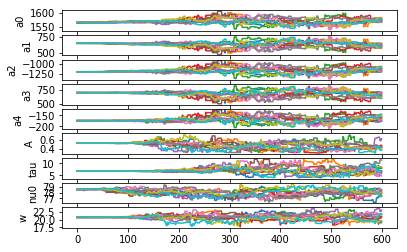

In [26]:
m21.check_burn_in(sampler)

Assessing these plots by eye, an appropriate burn-in period seems to be 300 steps. We can use the `model21cm.trim_to_frame` method to trim our MCMC sample set to exclude these burn-in steps. The method outputs the result (stacked along the walker axis) in two different formats, a nested array, and a pandas dataframe. 

In [27]:
traces, frame = m21.trim_to_frame(sampler, 300)

Using the `pandas.DataFrame.quantile` method, we report the median and $\pm \sigma$ values for each parameter from the sample. 

In [28]:
q = frame.quantile([0.16, 0.50, 0.84], axis=0)
q

#Recall we forward-generated our data about the point: 
#(1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0)

,a0,a1,a2,a3,a4,A,tau,nu0,w
0.16,1558.592911,575.112147,-1249.143140,615.014703,-184.495834,0.376577,5.338445,77.300668,19.797355
0.50,1570.029900,627.734823,-1166.735950,678.160801,-168.359695,0.456470,7.164087,77.920912,20.841992
0.84,1582.240793,679.593157,-1078.546552,737.116200,-151.813901,0.558084,9.463758,78.574942,21.973468


Finally, we can gain greater insight into our parameter uncertainties and cross-parameter correlations by generating a plots of partially-marginalized posterior distributions. We use the package `corner` to generate corner plots (a.k.a. "triangle plots") from the results of our MCMC chains. 

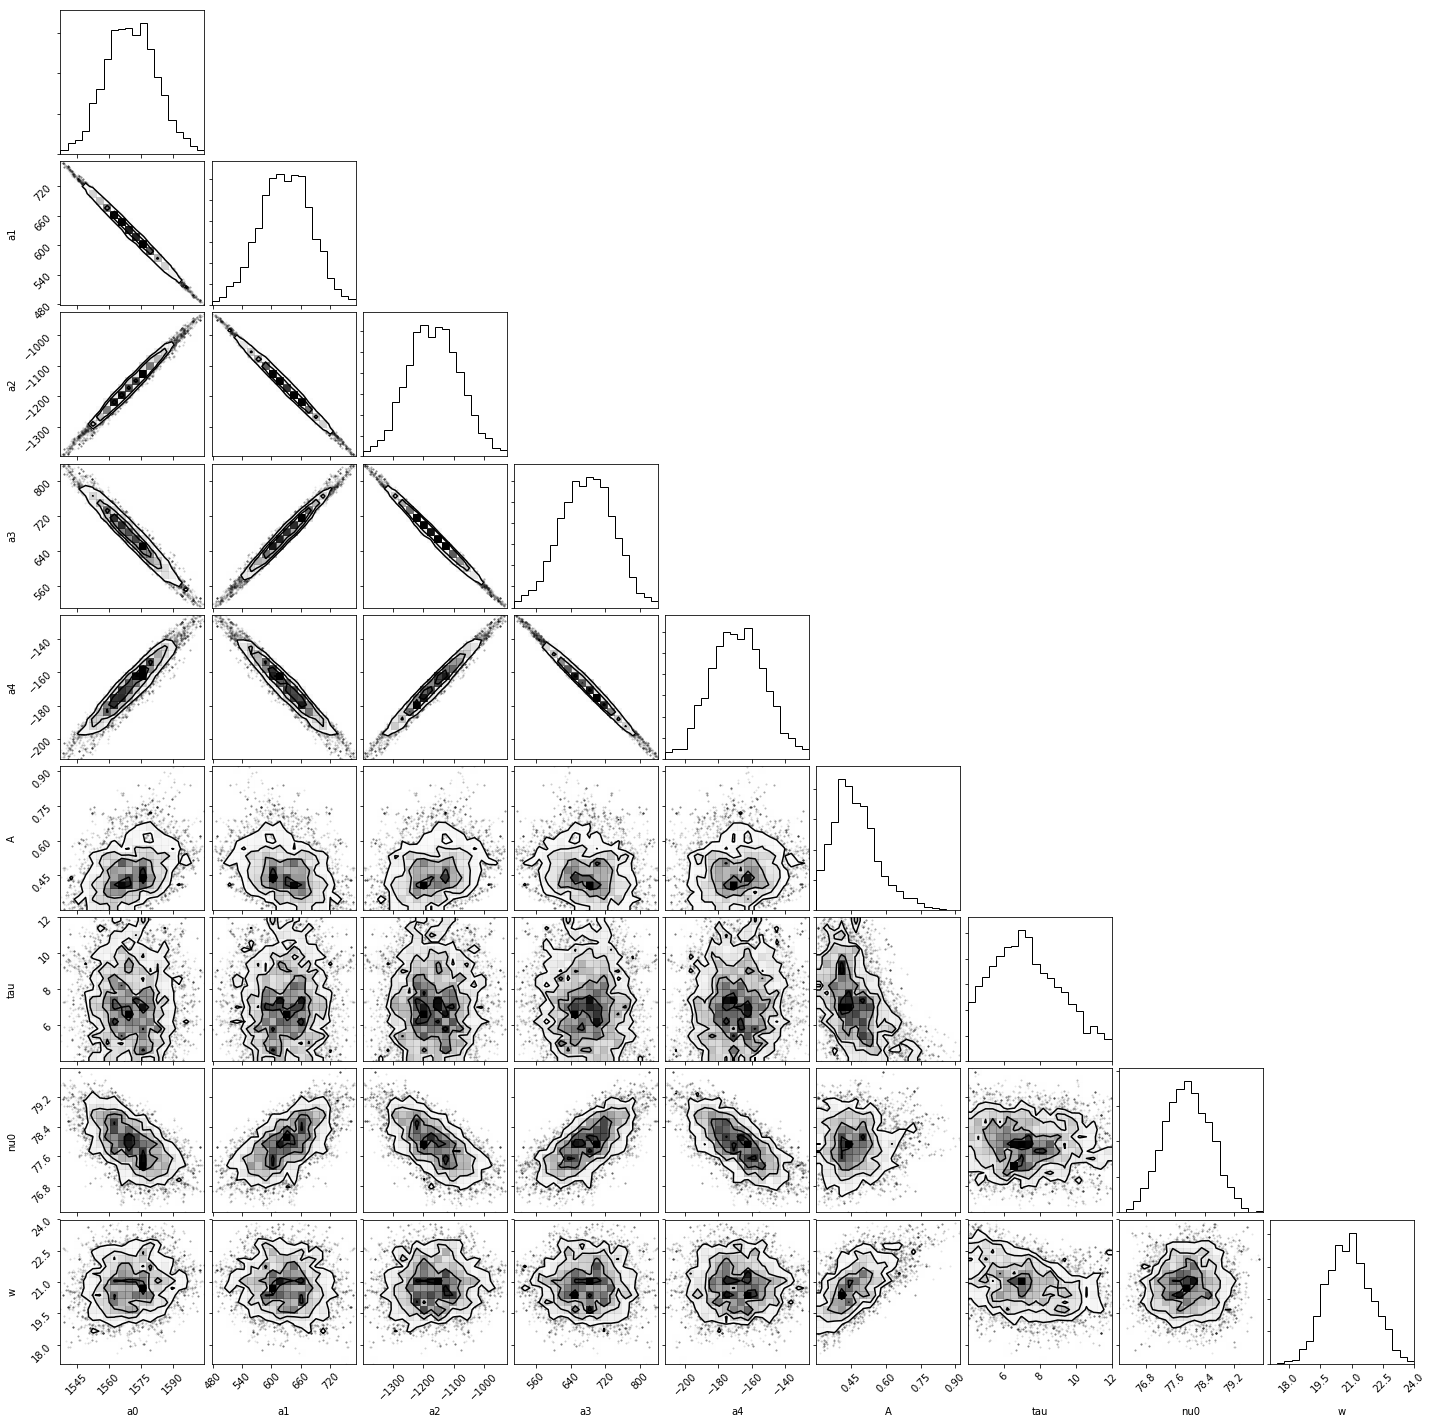

In [29]:
import corner
fig = corner.corner(traces.T, labels=['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau','nu0', 'w'])

While we can quickly identify that these chains are not well converged, this is due to the limited extent of sampling we performed. The `model21cm` package is also distributed with a scripted form of this notebook, as well as scripts to launch jobs in a cluster environment in order to take advantage of parallel processing capabilities. The results of larger chains calculated using such methods is included in the write-up for this project. 

# Dark Matter Extension to our Model 

With functional apparatus in-hand for performing inference on the standard EDGES model of the 21cm signal, we can demonstrate similar methods additional parameter $\xi$ dark matter extension discussed earlier. For clarity, we repeat some lines already used above. Generally, our procedure for utilizing `model21cm` is identical to the case above, except that now we take advantage of the `DarkModel` subclass of `Model` to generate our posterior. 

Our abbreviated walkthrough begins with initializing the 10 parameters of the model...

In [31]:
a0 = m21.Parameter('a0', 1530., 1650.)
a1 = m21.Parameter('a1', 450., 900.)
a2 = m21.Parameter('a2', -1400., -800.)
a3 = m21.Parameter('a3', 450., 900.)
a4 = m21.Parameter('a4', -225., -125.)
A = m21.Parameter('A', 0.3, 1.0)
tau = m21.Parameter('tau', 4., 12.)
nu0 = m21.Parameter('nu0', 76., 80.)
w = m21.Parameter('w', 17., 24.)
xi = m21.Parameter('xi', -10, 0)

Grouping them together... 

In [32]:
parameterlist = [a0, a1, a2, a3, a4, A, tau, nu0, w, xi]
parameters = m21.Parameters(parameter_list=parameterlist)
parameters.parameter_names()

['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau', 'nu0', 'w', 'xi']

Adding them to an instance of `DarkModel`... 

In [33]:
simulateddarkmodel = m21.DarkModel()
simulateddarkmodel.add_parameters(parameterlist)
simulateddarkmodel.parameters

['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau', 'nu0', 'w', 'xi']

Forward-generating data for the dark model... 

In [34]:
freq = m21.edgesdata.frequencies
params = (1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0, -0.1)
temp = m21.forwardmodel(freq, params, dark=True)
df = pd.DataFrame({'Frequencies': freq, 'Temperature': temp})

Adding the simulated data to our dark model... 

In [35]:
simulateddarkmodel.add_data(df)

And launchng the MCMC... _(Expected wait time: 2 mins)_

In [36]:
sampler = simulateddarkmodel.MCMC()

We then plot the chains... _(Expected wait time: 10 secs)_

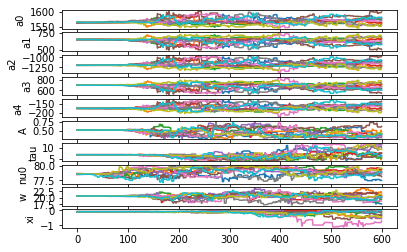

In [37]:
m21.check_burn_in(sampler, True)

We report the median and $\pm \sigma$ values for each parameter from the sample... 

In [38]:
traces, frame = m21.trim_to_frame(sampler, 300, True)
q = frame.quantile([0.16, 0.50, 0.84], axis = 0)
q

#Recall we forward-generated our data about the point: 
#(1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0,-0.1)

,a0,a1,a2,a3,a4,A,tau,nu0,w,xi
0.16,1557.427837,570.001546,-1261.239335,600.538958,-188.061123,0.362538,5.198786,78.089638,19.582839,-0.141082
0.50,1568.662969,639.020146,-1188.798394,699.021267,-174.319165,0.477139,6.467738,79.334865,20.721100,-0.092910
0.84,1582.289873,685.227679,-1063.626015,746.925216,-147.494244,0.610243,8.165686,79.721462,21.802274,-0.034057


Now we can proceed to generate our dark model triangle plot from the MCMC sample as above. However, when you run the line below, you will find that we did not run large enough chains to generate enough data points to produce valid contours. `corner` will issue several warnings about this. For the sake of your time, we excluded rerunning a larger MCMC in this notebook in favor of doing so on the cluster. The results of which you can find in the write-up of this package. For the sake of completeness, the code below was not removed from the notebook so that you can still view the initial formations towards a valid triangle plot. 

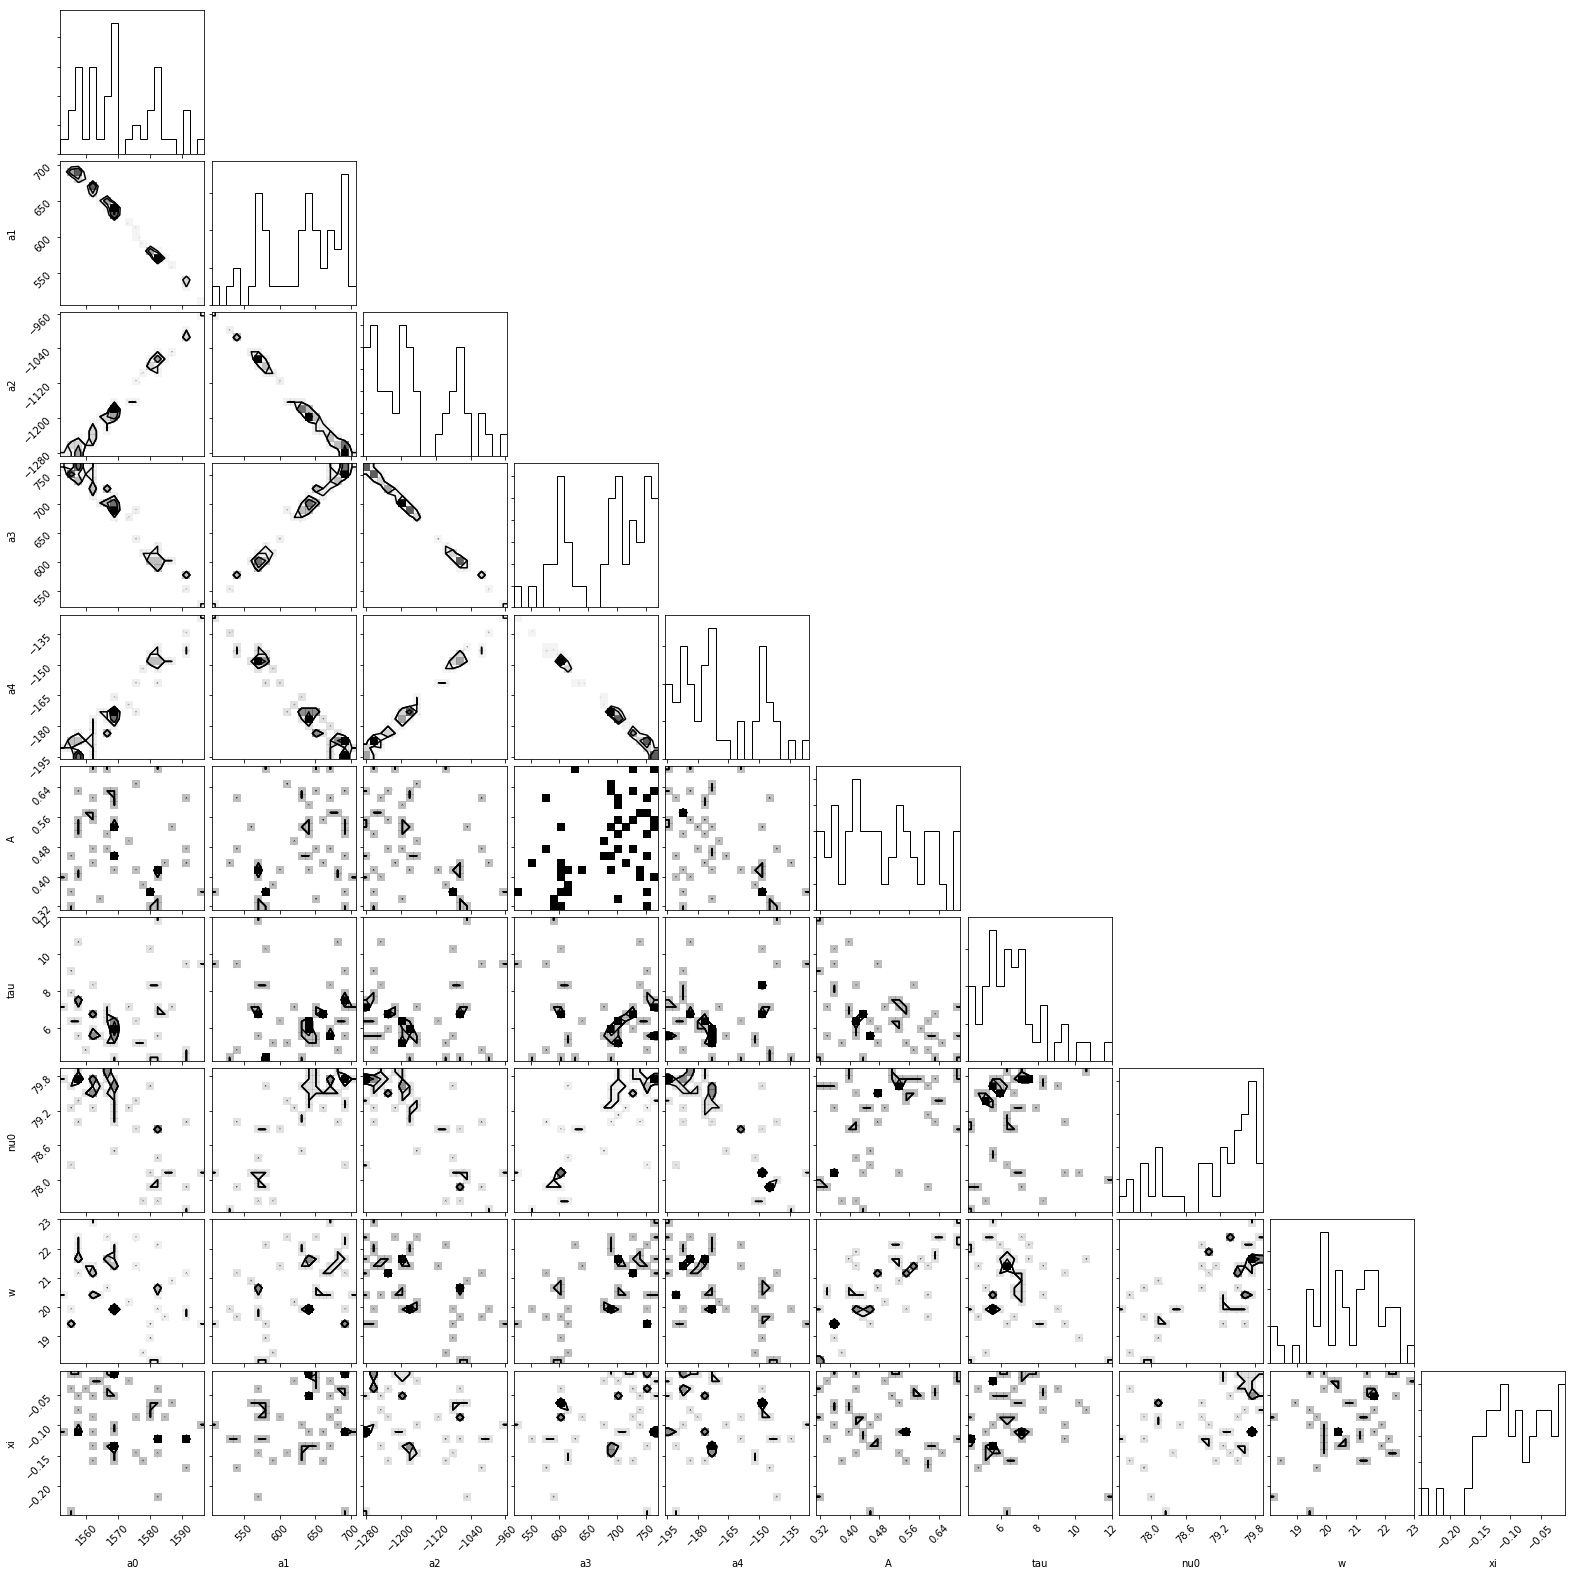

In [39]:
fig2 = corner.corner(traces.T, labels=['a0', 'a1', 'a2', 'a3', 'a4', 'A', 'tau','nu0', 'w','xi'])

# Perform Model Comparison

With the ability to generate priors, likelihoods and posteriors for both our EDGES model and Dark Matter Model, we are equipped with sufficient tools to perform Bayesian model comparison. Again for clarity, and to re-illustrate use of the `model21cm` package, we repeat code here that previously defined identical objects above. 

We begin by fully defining the EDGES model... 

In [11]:
a0 = m21.Parameter('a0', 1530., 1650.)
a1 = m21.Parameter('a1', 450., 900.)
a2 = m21.Parameter('a2', -1400., -800.)
a3 = m21.Parameter('a3', 450., 900.)
a4 = m21.Parameter('a4', -225., -125.)
A = m21.Parameter('A', 0.3, 1.0)
tau = m21.Parameter('tau', 4., 12.)
nu0 = m21.Parameter('nu0', 76., 80.)
w = m21.Parameter('w', 17., 24.)
parameterlist = [a0, a1, a2, a3, a4, A, tau, nu0, w]

m_EDGES = m21.Model("Normal EDGES Model")
m_EDGES.add_parameters(parameterlist)

params = (1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0)
freq = m21.edgesdata.frequencies
temp = m21.forwardmodel(freq, params, dark=False)
df = pd.DataFrame({'Frequencies': freq, 'Temperature': temp})

m_EDGES.add_data(df)

To perform the model comparison, we will implement a parallel-tempered MCMC for each of our models. Using the temperature ladder defined on pg. 330 of Gregory, we setup the parallel-tempered MCMC for the EDGES model with 20 walkers at 100 steps each...

In [14]:
# 9 parameters, 50 walkers, 200 steps, 5 temperatures
ndim = 9
nwalkers = 20
nsteps = 100
ntemps = 5

# Gregory (p. 330) temperature ladder
betas = np.array([1.0, 0.7525, 0.505, 0.2575, 0.01])

#Starting position in parameter space
start = np.array([1565, 650, -1200, 700, -174, 0.53, 6.8, 78.6, 20.7])

# np.tile copies an array and then stacks the copies.  
starting_positions = np.tile(start, (ntemps,nwalkers,1))*(1. + 1.e-4*np.random.randn(ntemps, nwalkers, ndim))

Then, we perform the parallel-tempered MCMC using the `emcee.PTSampler` method, providing our likelihood and prior functions from our model to this method... 

_(Expected wait time: 45 sec)_

In [5]:
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, m_EDGES.loglikelihood_at, m_EDGES.globallogprior_at, 
                          betas = betas)
_ = sampler.run_mcmc(starting_positions, nsteps)

After manually assessing the chains, we set a burn-in period and use the `thermodynamic_integration_log_evidence` method from `emcee` to get the value:  $~~\log{P(D|M)}$. 

In [9]:
burnin = 50

sampler.thermodynamic_integration_log_evidence(fburnin=burnin/nsteps)

(-60.9680637999856, 3.0277377043194775)

We must now repeat these steps for the Dark Model. Doing so, we find:  

_(Expected wait time: 45 secs)_

In [16]:
#Input parameters to model
xi = m21.Parameter('xi', -10, 0)
parameterlist = [a0, a1, a2, a3, a4, A, tau, nu0, w, xi]

m_DARK = m21.DarkModel("Dark EDGES Model")
m_DARK.add_parameters(parameterlist)

#Input data to model 
freq = m21.edgesdata.frequencies
temp = m21.forwardmodel(freq, (1565, 650, -1200, 700, -174, 0.43, 6.8, 78.6, 20.0, -0.1), dark=True)
df = pd.DataFrame({'Frequencies': freq, 'Temperature': temp})

m_DARK.add_data(df)

#10 parameters, 50 walkers, 200 steps each, 5 temperatures 
ndim = 10
nwalkers = 20
nsteps = 100
ntemps = 5

#Gregory (see p. 330) temperature ladder
betas = np.array([1.0, 0.7525, 0.505, 0.2575, 0.01])

#Setup the walkers
start = np.array([1565, 650, -1200, 700, -174, 0.53, 6.8, 78.6, 20.7,-0.1])
starting_positions = np.tile(start, (ntemps,nwalkers,1))*(1. + 1.e-4*np.random.randn(ntemps, nwalkers, ndim))

#Setup sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, m_DARK.loglikelihood_at, m_DARK.globallogprior_at, 
                          betas = betas)

#Run the sampler
_ = sampler.run_mcmc(starting_positions, nsteps)

#Set burn-in
burnin = 50

#Compute P(D|M)
sampler.thermodynamic_integration_log_evidence(fburnin=burnin/nsteps)

(-84.05670097410359, 3.4256639649686917)

With values calculated for each of our models, we have everything we need to compute the odds ratio and use that as evidence towards accepting/rejecting one model over the other. Recall the odds ratio is given by: 

$$ \mathcal{O}_{12} = \frac{P(M_1)}{P(M_2)} \frac{P(D|M_1)}{P(D|M_2)} $$
$$ \Rightarrow ln\big( \mathcal{O}_{12} \big)  = ln\Big( \frac{P(M_1)}{P(M_2)} \Big) + ln\big(P(D|M_1)\big) - ln\big(P(D|M_2)\big) $$

In our case, we assume equal _a priori_ probabilities for each of our models 

$$\Rightarrow ~~P(M_1)=P(M_2)~~\Rightarrow~~ln\Big( \frac{P(M_1)}{P(M_2)} \Big) = 0$$

The log of the Bayes Factor is then simply given by the difference of our results above, that is: 

$$ln\big( \mathcal{O}_{12} \big) = ln\big(B_{ij}\big) = (-66.890) - (-78.630) = 11.740 $$
$$ \Rightarrow \mathcal{O}_{12} = B_{ij} = 125,492.340 $$

So, it appears that the odds ratio lends evidence that model 1, the original EDGES model, is favored over the Dark Model. However, you should place little faith in this result. Recall that we calculated each component of the Bayes Factor using a different dataset generated by a forward model. A valid comparison requires us to draw our conclusion from a single, real dataset. We must now use the real data to draw a final conclusion. 

As far as a user tutorial goes (and for the sake of building suspense), performing this last analysis in the notebook would not contribute much to learning how to use the `model21cm` package. So, we omit it. Instead, the results of perforing this analysis on a cluster machine are included in the package write-up. 